In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#dataset 

! git clone https://github.com/MichaelGerhard/PlantDiseaseData

Cloning into 'PlantDiseaseData'...
remote: Enumerating objects: 2, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 54367 (delta 0), reused 0 (delta 0), pack-reused 54365
Receiving objects: 100% (54367/54367), 803.83 MiB | 38.18 MiB/s, done.
Checking out files: 100% (54305/54305), done.


In [ ]:
#importing necessary libraries and APIs
import warnings
warnings.filterwarnings("ignore")
import os
import glob
import matplotlib.pyplot as plt
import keras

from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten
from keras.layers import Conv2D,MaxPooling2D,Activation,AveragePooling2D,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#sets paths

train_dir ="/content/PlantDiseaseData/Train"
test_dir="/content/PlantDiseaseData/Test"


In [ ]:
#function that counts the number of files in a dierctory
def get_files(dir):
  if not os.path.exists(dir):
    return 0
  c=0 #initialize count with zero
  for curr_path,dirs,files in os.walk(dir):
    for d in dirs:
      c+= len(glob.glob(os.path.join(curr_path,d+"/*")))

  return c

In [ ]:
train_samples =get_files(train_dir)
num_classes=len(glob.glob(train_dir+"/*"))
test_samples=get_files(test_dir) 
print(num_classes,"classes")
print(train_samples,"Training images")
print(test_samples,"Testing images")

38 Classes
43429 Train images
10876 Test images


In [ ]:
#data generator to generate images 

train_datagen=ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, validation_split=0.2, horizontal_flip=True)
test_datagen=ImageDataGenerator(rescale=1./255)

In [ ]:
img_width,img_height =224,224 #sizes are compatible with MobileNet
input_shape=(img_width,img_height,3)
batch_size =64
train_generator =train_datagen.flow_from_directory(train_dir,shuffle=True, target_size=(img_width,img_height), 
                                                   batch_size=batch_size, subset='training')

validation_generator =train_datagen.flow_from_directory(train_dir,shuffle=True,target_size=(img_width,img_height),
                                                   batch_size=batch_size, subset='validation')

test_generator=test_datagen.flow_from_directory(test_dir,shuffle=True, target_size=(img_width,img_height),
                                                   batch_size=batch_size)

Found 34756 images belonging to 38 classes.
Found 8673 images belonging to 38 classes.
Found 10876 images belonging to 38 classes.


In [ ]:

for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape



((64, 224, 224, 3), (64, 38))

In [ ]:
print (train_generator.class_indices)
labels = '\n'.join(sorted(train_generator.class_indices.keys()))
with open('labels.txt', 'w') as f:
  f.write(labels)

{'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacterial_spot': 18, 'Pepper,_bell___healthy': 19, 'Potato___Early_blight': 20, 'Potato___Late_blight': 21, 'Potato___healthy': 22, 'Raspberry___healthy': 23, 'Soybean___healthy': 24, 'Squash___Powdery_mildew': 25, 'Strawberry___Leaf_scorch': 26, 'Strawberry___healthy': 27, 'Tomato___Bacterial_spot': 28, 'Tomato___Early_blight': 29, 'Tomato___Late_blight': 30, 'Tomato

In [ ]:
#image shape is 224x224x3
IMG_SHAPE = (img_width, img_height, 3)
# base model is the pre-trained model MobileNet V2 (from keras library)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')
base_model.trainable=False

In [ ]:

#Adding the layers (model 1)
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(32, 3, activation='elu'),
  tf.keras.layers.Dropout(0.5),  #increase dropout
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(38, activation='softmax')
])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
model.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout_5 (Dropout)          (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d_5 ( (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 38)                1254      
Total params: 2,627,910
Trainable params: 369,926
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
epochs = 10
history = model.fit(train_generator, 
                    epochs=epochs, 
                    validation_data=validation_generator)

Epoch 1/10
544/544 [==============================] - 456s 838ms/step - loss: 0.7657 - accuracy: 0.7831 - val_loss: 0.4106 - val_accuracy: 0.8678
Epoch 2/10
544/544 [==============================] - 455s 836ms/step - loss: 0.3623 - accuracy: 0.8849 - val_loss: 0.2724 - val_accuracy: 0.9110
Epoch 3/10
544/544 [==============================] - 454s 835ms/step - loss: 0.2788 - accuracy: 0.9082 - val_loss: 0.2983 - val_accuracy: 0.9015
Epoch 4/10
544/544 [==============================] - 454s 835ms/step - loss: 0.2458 - accuracy: 0.9192 - val_loss: 0.2325 - val_accuracy: 0.9246
Epoch 5/10
544/544 [==============================] - 454s 835ms/step - loss: 0.2450 - accuracy: 0.9185 - val_loss: 0.2353 - val_accuracy: 0.9219
Epoch 6/10
544/544 [==============================] - 456s 838ms/step - loss: 0.2177 - accuracy: 0.9277 - val_loss: 0.2253 - val_accuracy: 0.9294
Epoch 7/10
544/544 [==============================] - 456s 838ms/step - loss: 0.2080 - accuracy: 0.9311 - val_loss: 0.2321 -

In [ ]:
score = model.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

170/170 [==============================] - 24s 141ms/step - loss: 0.2316 - accuracy: 0.9234
Test loss: 0.23159529268741608
Test accuracy: 0.9234093427658081


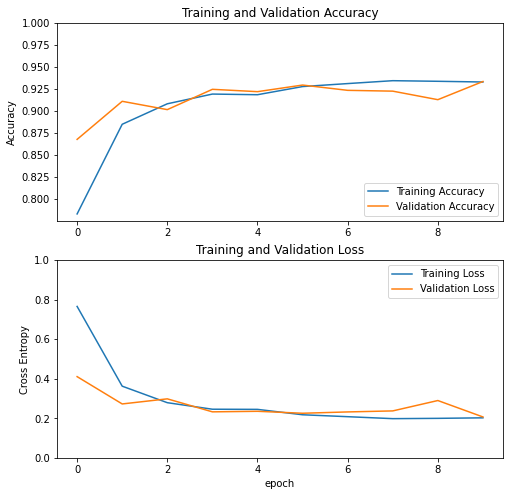

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True


In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(1e-5),
              metrics=['accuracy'])

In [ ]:
model.summary()


In [ ]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))


In [ ]:
history_fine = model.fit_generator(train_generator, 
                         epochs=5,
                         validation_data=val_generator)

In [ ]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:

saved_model_dir = 'save/fine_tuning'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
from google.colab import files

files.download('./model.tflite')
files.download('./labels.txt')


In [ ]:
#Add code to load model and continue working on it here
#Add code to continue predictions here